In [1]:
from extract_utils import *

# Pre-Processing Outline

1. Epochs for selected region (window=5s)
2. Transform raw data to frequency domain, look for peaks at 0.4-5 Hz
3. outliners identification -- e.g. 95% percentile
4. Filter out epochs based on:
    - peaks at 0.4-5 Hz
    - within 95% percentile of power? 


## Obtain relevant patient info

- Here we choose patient 8 for our analysis
- Figure shown below indicidates the position of electrodes on this patient

![elecLoc](Data/electrodePos/ep_sbj_08.png)

In [2]:
# get the nwb file
file, _ = get_nwb('08', 3)

/Applications/anaconda3/envs/NMA/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NMA/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NMA/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.4.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [3]:
# table of epochs for all behavioural type
allActs, blocklist, acts, epochs = get_epochs(file, True)

# get raw data
raw = file.acquisition['ElectricalSeries'].data
# get good electrode id defined in the literature
goodid = file.electrodes.to_dataframe()[file.electrodes.to_dataframe()['good']==True].index

## Obtain Epochs for each behaviors

In [4]:
# extract all inactive activities
inactive = extract_phys_accod_timestamps(raw, epochs['Inactive'], [0, 24])
# use the average as baseline
d = []
for item in inactive.keys():
    temp = epoching(inactive[item], 500, epoch=94, max_t=94)[:, goodid.values,:]
    if not np.isnan(temp).any():
        d.append(temp) # leave only good electrodes
        

inactiveArray = np.dstack(d)
inactiveArray.shape
baseline = inactiveArray.mean(axis=2)

In [5]:
epochs_behavior = {} # Mapping behavior to corresponding epochs of 5s

for item in acts:
    # extract recording by bahvior
    if item == 'Inactive' or item=='Other activity' or item=='Sleep/rest':
        pass
    else:
        temp = extract_phys_accod_timestamps(raw, epochs[item], [0, 24])
        # obtain epochs for each behaviour
        d = []
        for key in temp.keys():
            d.append(epoching(temp[key], 500, 94, max_t=94)[:, goodid.values,:]) # leave only good electrodes
        epochs_behavior[item] = np.dstack(d)

## Power Transform

In [6]:
import fooof as f
import scipy
from scipy.signal import welch, firwin, fftconvolve, hilbert
from scipy.fft import ifft
from scipy.signal import sosfilt

In [7]:
acts = ['Computer/phone',
 'Eat, TV',
 'TV',
 'TV, Computer/phone',
 'Talk',
 'Talk, Computer/phone',
 'Talk, TV',
 'Talk, TV, Computer/phone']

In [8]:
# 2th order IIR filter to extract low-frequence envelop
filter_order = 2
neural_freq_range = [0.5, 5]
sampling_rate = 500
filtered_data = {}
for item in acts:
        item_specific = np.empty((epochs_behavior[item].shape))
        for j in range(epochs_behavior[item].shape[1]):
                neur_data_curr = epochs_behavior[item][:, j, :]
                sos = butter(filter_order, neural_freq_range, btype='bandpass', output='sos', fs=sampling_rate)
                item_specific[:, j, :] = sosfiltfilt(sos, neur_data_curr, padlen=0)
        filtered_data[item] = item_specific

In [9]:
epochs_behavior[item].shape

(47000, 83, 1)

In [10]:
freqb, spectrumb = welch(baseline[:, -1], 500, scaling='spectrum')

In [11]:
# Select epochs with power within 99% percentile

epoch_id = {}
tl, n_channel, n_epoch = epochs_behavior['TV'].shape
powerSpec = np.empty((tl, n_channel, n_epoch))
filtered_epochs = {}

l_c = []
filtered_epochs['TV'] = {}
for j in range(n_channel): # for each channel
    
    channel_curr = []
    for i in range(n_epoch): # for each epoch
        # Hilbert transform on filtered data
        # powerSpec[:, j, i] = np.abs(hilbert(filtered_data['TV'][:, j, i], ))
        # channel_curr.append(power)
        # welch transform
        freqs, spectrum = welch(epochs_behavior['TV'][:, j, i], fs=500, scaling='density')
        #spectrum = 10*np.log10(spectrum/spectrumb)
        channel_curr.append(np.mean(spectrum[0:3]))
    lb, ub = np.percentile(channel_curr, [5, 95])
    idx = np.where(np.logical_and(channel_curr<=ub, channel_curr>=lb))
    l_c.append(len(idx[0]))
    filtered_epochs['TV'][j] = epochs_behavior['TV'][:, j, idx]

minlidx = min(l_c)
epochf = np.empty((tl, n_channel, minlidx))
for j in range(n_channel):
    t, lepoch = filtered_epochs['TV'][j].shape[0], filtered_epochs['TV'][j].shape[-1]
    filtered_epochs['TV'][j] = filtered_epochs['TV'][j].reshape(t, lepoch)
    epochf[:, j, :] = filtered_epochs['TV'][j][:, 0:minlidx]

# (filtered_data['TV'][:, :, i] - np.mean(baseline, axis=1))/std()

In [13]:
# z-scoring
for i in range(n_epoch):
    powerSpec[:, :, i] = (powerSpec[:, :, i] - np.mean(baseline, axis=0)
)/np.std(baseline, axis=0)

(0.0, 50.0)

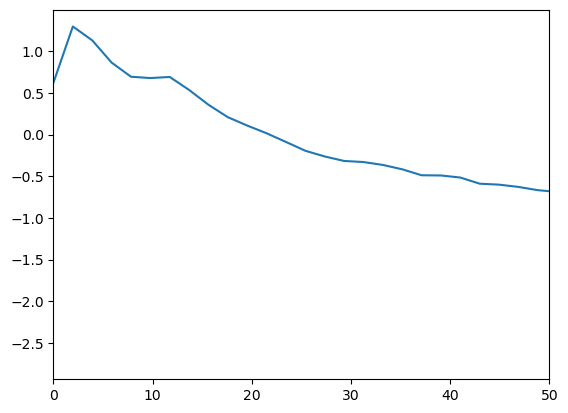

In [14]:
plt.plot(freqs, np.log10(spectrum))
plt.xlim([0, 50])

## MNE demo

In [49]:
from mne.viz import plot_raw_psd
import mne

In [16]:
sample = epochs_behavior['TV']
sample.shape

(47000, 83, 23)

In [39]:
file.electrodes.to_dataframe()

,x,y,z,imp,location,filtering,group,group_name,standard_deviation,kurtosis,median_deviation,good,low_freq_R2,high_freq_R2
id,,,,,,,,,,,,,,
0,41.134738,26.050913,-33.452157,NaN,unknown,250 Hz lowpass,GRID pynwb.ecephys.ElectrodeGroup at 0x6264068...,GRID,288.289327,2375.833741,15.331931,False,-0.005928,-0.005575
1,50.174158,18.296162,-34.163669,NaN,unknown,250 Hz lowpass,GRID pynwb.ecephys.ElectrodeGroup at 0x6264068...,GRID,52.512169,19.575736,39.152813,True,-0.003253,-0.002361
2,59.031132,6.545674,-33.336422,NaN,unknown,250 Hz lowpass,GRID pynwb.ecephys.ElectrodeGroup at 0x6264068...,GRID,56.935398,10664.780819,32.823629,False,0.002872,0.001557
3,62.800550,-5.665454,-29.271763,NaN,unknown,250 Hz lowpass,GRID pynwb.ecephys.ElectrodeGroup at 0x6264068...,GRID,27.258058,6.024034,22.673367,True,-0.003130,-0.005625
4,65.658658,-14.584315,-25.938843,NaN,unknown,250 Hz lowpass,GRID pynwb.ecephys.ElectrodeGroup at 0x6264068...,GRID,51.833299,6.757355,42.433192,True,-0.005027,-0.003978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,57.588535,-53.469287,-26.214248,NaN,unknown,250 Hz lowpass,RPT pynwb.ecephys.ElectrodeGroup at 0x62640678...,RPT,22.341249,8.020028,17.901196,True,-0.000943,0.010240
88,63.891590,-44.880777,-28.918419,NaN,unknown,250 Hz lowpass,RPT pynwb.ecephys.ElectrodeGroup at 0x62640678...,RPT,30.739718,7.289480,24.114064,True,-0.000445,-0.003442
89,67.621558,-34.120524,-27.609087,NaN,unknown,250 Hz lowpass,RPT pynwb.ecephys.ElectrodeGroup at 0x62640678...,RPT,32.916244,6.572947,25.552524,True,-0.008798,-0.011766


In [40]:
file

root pynwb.file.NWBFile at 0x6263585904
Fields:
  acquisition: {
    ElectricalSeries <class 'pynwb.ecephys.ElectricalSeries'>
  }
  devices: {
    GRID <class 'pynwb.device.Device'>,
    RAT <class 'pynwb.device.Device'>,
    RMT <class 'pynwb.device.Device'>,
    ROF <class 'pynwb.device.Device'>,
    RPT <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    GRID <class 'pynwb.ecephys.ElectrodeGroup'>,
    RAT <class 'pynwb.ecephys.ElectrodeGroup'>,
    RMT <class 'pynwb.ecephys.ElectrodeGroup'>,
    ROF <class 'pynwb.ecephys.ElectrodeGroup'>,
    RPT <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  epochs: epochs <class 'pynwb.epoch.TimeIntervals'>
  file_create_date: [datetime.datetime(2021, 6, 9, 8, 21, 44, 388720, tzinfo=tzoffset(None, -14400))]
  identifier: 02bcd382-95f1-43ee-9239-fbd13a5a3906
  intervals: {
    epochs <class 'pynwb.epoch.TimeIntervals'>,
    reaches <class 'pynwb.epoch.TimeIntervals'>
  }
  processing: {
    behavior <class 'pynwb.base.ProcessingModule'>
  }
  session_description: no description
  session_id: 3
  session_start_time: 2000-01-02 19:00:00-05:00
  subject: subject pynwb.file.Subject at 0x6264068176
Fields:
  species: Homo sapiens
  subject_id: 08

  timestamps_reference_time: 2000-01-02 19:00:00-05:00

In [44]:
sample.shape

(47000, 83, 23)

In [46]:
sampleinfo = mne.create_info([str(id) for id in goodid], 500, 'ecog')
epochObj = mne.EpochsArray(sample.T, info=sampleinfo)

Not setting metadata
23 matching events found


No baseline correction applied
0 projection items activated


    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/var/folders/lw/hwgr0trd2fvc2gxpptkrl8m00000gn/T/ipykernel_5487/2833124722.py:1: RuntimeWarning: in version 1.5, the default behavior of Spectrum.plot() will change so that bad channels will be shown by default. To keep the old default behavior (and silence this warning), explicitly pass `picks='data', exclude='bads'`.
  epochObj.compute_psd().plot()
/var/folders/lw/hwgr0trd2fvc2gxpptkrl8m00000gn/T/ipykernel_5487/2833124722.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochObj.compute_psd().plot()
/Applications/anaconda3/envs/NMA/lib/python3.9/site-packages/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


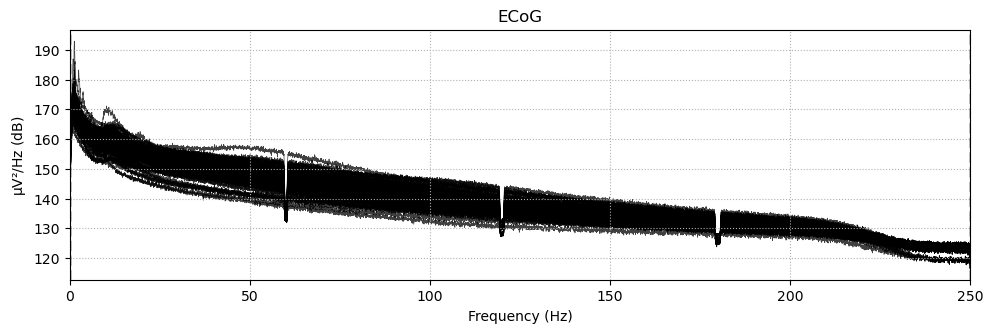

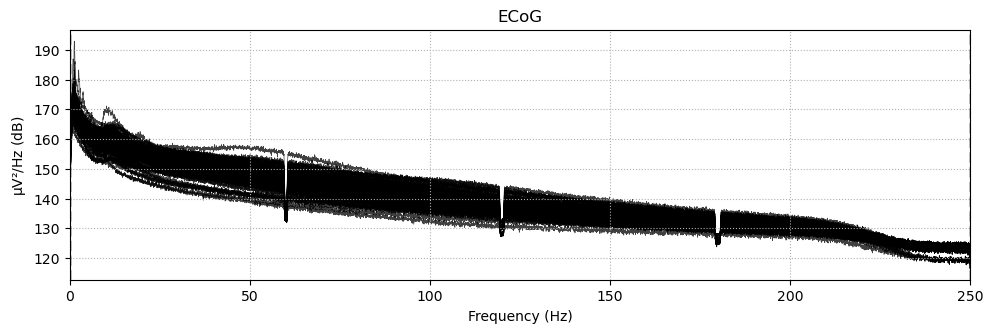

In [47]:
epochObj.compute_psd().plot()

In [56]:
sample.T.shape

(23, 83, 47000)

    Using multitaper spectrum estimation with 7 DPSS windows


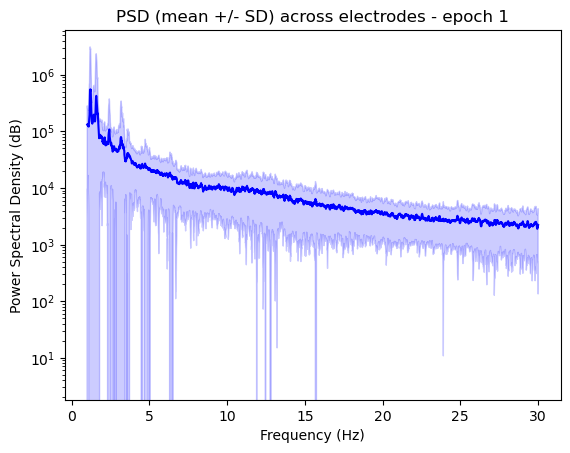

In [57]:
psds, freqs = mne.time_frequency.psd_array_multitaper(sample.T, sfreq=500, fmin=1., fmax=30.)
mean_psd = np.mean(psds, axis=1)
std_psd = np.std(psds, axis=1)
plt.figure()
plt.semilogy(freqs, mean_psd[0], color='b')
plt.fill_between(freqs, mean_psd[0] - std_psd[0], mean_psd[0] + std_psd[0],
                 color='b', alpha=.2)
plt.title('PSD (mean +/- SD) across electrodes - epoch 1')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.show()

# Demixed PCA